<a href="https://colab.research.google.com/github/evildead23151/F1-Prediction-Models/blob/main/Predicting_Dutch_GrandPrix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Check and enable GPU
import subprocess, sys, os, textwrap, platform
!nvidia-smi || echo "No GPU visible"

# Install deps
!pip -q install fastf1 pandas numpy scikit-learn xgboost tqdm python-dateutil joblib

# Optional: persist cache to Drive (uncomment to use Drive)
# from google.colab import drive
# drive.mount('/content/drive')
# CACHE_DIR = "/content/drive/MyDrive/f1_fastf1_cache"  # persistent but slower than local
CACHE_DIR = "/content/f1_cache"  # fast local cache (reset on runtime end)

import os
os.makedirs(CACHE_DIR, exist_ok=True)
print("Cache dir:", CACHE_DIR)

Sat Aug 16 10:15:00 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   62C    P8             13W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import fastf1
import pandas as pd
import numpy as np
from tqdm import tqdm

fastf1.Cache.enable_cache(CACHE_DIR)  # required for FastF1 to store timing data

def load_session(season: int, rnd: int, name: str):
    ses = fastf1.get_session(season, rnd, name)  # "FP1","FP2","FP3","Q","R"
    ses.load()  # downloads and caches timing data
    return ses

def extract_quali_features(q_session) -> pd.DataFrame:
    qres = q_session.results
    cols = ["DriverNumber","Abbreviation","DriverId","TeamName","TeamColor","Position","Q1","Q2","Q3"]
    df = qres[cols].copy()
    df.rename(columns={"Position":"quali_position"}, inplace=True)
    # Convert session lap time strings to seconds
    for c in ["Q1","Q2","Q3"]:
        df[c] = pd.to_timedelta(df[c], errors="coerce").dt.total_seconds()
    return df

def extract_race_labels(r_session) -> pd.DataFrame:
    rres = r_session.results
    cols = ["DriverNumber","Abbreviation","DriverId","TeamName","TeamColor","GridPosition","Position","Status","Points"]
    df = rres[cols].copy()
    df.rename(columns={"Position":"finish_position","GridPosition":"grid_position"}, inplace=True)
    df["finish_position"] = pd.to_numeric(df["finish_position"], errors="coerce")
    df["grid_position"] = pd.to_numeric(df["grid_position"], errors="coerce")
    return df

def compute_driver_recent_form(df: pd.DataFrame, window:int=5) -> pd.DataFrame:
    # df is driver-event historical with finish_position, Status, Points, season, round
    df = df.sort_values(["DriverId","season","round"]).copy()
    def _g(g):
        g = g.copy()
        g["finish_pos_rolling_mean"] = g["finish_position"].shift(1).rolling(window, min_periods=1).mean()
        g["dnf_rate_rolling"] = (
            g["Status"].shift(1).fillna("")
            .str.contains("Retired|DNF|Accident|Engine|Gearbox|Hydraulics|Electrical|Brakes|Collision", case=False)
            .astype(int)
        ).rolling(window, min_periods=1).mean()
        g["points_rolling_mean"] = g["Points"].shift(1).rolling(window, min_periods=1).mean()
        return g
    return df.groupby("DriverId", group_keys=False).apply(_g)


In [3]:
def build_driver_event_table(seasons=range(2018, 2025), max_rounds=25) -> pd.DataFrame:
    rows = []
    for season in seasons:
        for rnd in range(1, max_rounds+1):
            try:
                race = load_session(season, rnd, "R")
            except Exception:
                continue
            race_df = extract_race_labels(race)
            race_df["season"] = season
            race_df["round"] = rnd

            try:
                quali = load_session(season, rnd, "Q")
                quali_df = extract_quali_features(quali)
            except Exception:
                quali_df = None

            if quali_df is not None:
                merged = pd.merge(
                    race_df,
                    quali_df.drop(columns=["TeamName","TeamColor"]),
                    on=["DriverId","DriverNumber","Abbreviation"],
                    how="left"
                )
            else:
                merged = race_df.copy()
                merged["quali_position"] = np.nan
                merged["Q1"] = np.nan
                merged["Q2"] = np.nan
                merged["Q3"] = np.nan

            merged["event_key"] = f"{season}_{rnd}"
            rows.append(merged)
    if not rows:
        return pd.DataFrame()
    df = pd.concat(rows, ignore_index=True)
    df = compute_driver_recent_form(df, window=5)
    return df

df_hist = build_driver_event_table()
df_hist.to_csv("/content/driver_event_dataset.csv", index=False)
df_hist.head(3), df_hist.shape


Streaming output truncated to the last 5000 lines.
DEBUG:fastf1.fastf1.events:Traceback for failure in Ergast API Schedule
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/fastf1/logger.py", line 151, in __wrapped
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/fastf1/events.py", line 746, in _get_schedule_from_ergast
    season = fastf1.ergast.fetch_season(year)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/fastf1/ergast/legacy.py", line 29, in fetch_season
    Cache.requests_get(url, headers=_headers))
    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/fastf1/req.py", line 303, in requests_get
    return cls._cached_request('GET', url, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/fastf1/req.py", line 347, in _cached_request
    res

(   DriverNumber Abbreviation DriverId TeamName TeamColor  grid_position  \
 4            14          ALO   alonso  McLaren    FF8700           10.0   
 26           14          ALO   alonso  McLaren    FF8700           13.0   
 46           14          ALO   alonso  McLaren    FF8700           13.0   
 
     finish_position    Status  Points  season  round  quali_position      Q1  \
 4               5.0  Finished    10.0    2018      1            11.0  83.597   
 26              7.0    +1 Lap     6.0    2018      2            13.0  90.530   
 46              7.0  Finished     6.0    2018      3            13.0  93.428   
 
         Q2  Q3 event_key  finish_pos_rolling_mean  dnf_rate_rolling  \
 4   83.692 NaN    2018_1                      NaN               0.0   
 26  90.212 NaN    2018_2                      5.0               0.0   
 46  93.232 NaN    2018_3                      6.0               0.0   
 
     points_rolling_mean  
 4                   NaN  
 26                 10.0

In [4]:
import xgboost as xgb
from sklearn.model_selection import GroupKFold
from sklearn.metrics import mean_absolute_error

FEATURES = [
    "grid_position","quali_position","Q1","Q2","Q3",
    "finish_pos_rolling_mean","dnf_rate_rolling","points_rolling_mean"
]
CATEGORICAL = ["DriverId","Abbreviation","TeamName"]  # we will one-hot encode simply for XGB

def prepare_xy(df: pd.DataFrame):
    df = df.dropna(subset=["finish_position"]).copy()


    for f in FEATURES:
        if f in df.columns:
            df[f] = pd.to_numeric(df[f], errors="coerce")
            df[f] = df[f].fillna(df[f].median())


    X = df[FEATURES].copy()
    cat = pd.get_dummies(df[CATEGORICAL].astype(str), dummy_na=True)
    X = pd.concat([X, cat], axis=1)
    y = df["finish_position"].astype(float)
    groups = df["event_key"]
    return X, y, groups

X, y, groups = prepare_xy(df_hist)

def train_xgb_gpu_cv(X, y, groups, n_splits=5, seed=42):
    gkf = GroupKFold(n_splits=n_splits)
    maes = []
    models = []
    for tr_idx, va_idx in gkf.split(X, y, groups=groups):
        dtr = xgb.DMatrix(X.iloc[tr_idx], label=y.iloc[tr_idx])
        dva = xgb.DMatrix(X.iloc[va_idx], label=y.iloc[va_idx])
        params = {
            "objective": "reg:squarederror",
            "eval_metric": "mae",
            "tree_method": "gpu_hist",
            "max_depth": 7,
            "eta": 0.05,
            "subsample": 0.9,
            "colsample_bytree": 0.9,
            "seed": seed
        }
        evallist = [(dtr, "train"), (dva, "valid")]
        model = xgb.train(
            params, dtr, num_boost_round=3000, evals=evallist,
            early_stopping_rounds=150, verbose_eval=200
        )
        yhat = model.predict(dva, iteration_range=(0, model.best_iteration+1))
        mae = mean_absolute_error(y.iloc[va_idx], np.round(yhat))
        maes.append(mae)
        models.append(model)
    return models, maes

models, maes = train_xgb_gpu_cv(X, y, groups)
print("Fold MAEs:", maes, "Avg:", sum(maes)/len(maes))
best_model = models[np.argmin(maes)]
best_model.save_model("/content/baseline_xgb_gpu.json")


/usr/local/lib/python3.11/dist-packages/xgboost/callback.py:386: UserWarning: [11:24:11] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  self.starting_round = model.num_boosted_rounds()


[0]	train-mae:4.81045	valid-mae:4.92091
[178]	train-mae:0.45429	valid-mae:4.49522
[0]	train-mae:4.85040	valid-mae:4.90373


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:729: UserWarning: [11:24:12] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  return func(**kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/callback.py:386: UserWarning: [11:24:12] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  self.starting_round = model.num_boosted_rounds()


[187]	train-mae:0.46942	valid-mae:3.73861
[0]	train-mae:4.84864	valid-mae:4.92056


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:729: UserWarning: [11:24:13] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  return func(**kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/callback.py:386: UserWarning: [11:24:13] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  self.starting_round = model.num_boosted_rounds()


[200]	train-mae:0.49733	valid-mae:3.48169
[284]	train-mae:0.25041	valid-mae:3.50612
[0]	train-mae:4.85624	valid-mae:4.89666


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:729: UserWarning: [11:24:13] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  return func(**kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/callback.py:386: UserWarning: [11:24:13] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  self.starting_round = model.num_boosted_rounds()


[200]	train-mae:0.43976	valid-mae:3.40611
[258]	train-mae:0.26731	valid-mae:3.41713
[0]	train-mae:4.82966	valid-mae:4.90282


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:729: UserWarning: [11:24:14] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  return func(**kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/callback.py:386: UserWarning: [11:24:14] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  self.starting_round = model.num_boosted_rounds()


[200]	train-mae:0.43340	valid-mae:4.04899
[201]	train-mae:0.42882	valid-mae:4.04850
Fold MAEs: [4.32, 3.6375, 3.4375, 3.325, 3.9375] Avg: 3.7314999999999996


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:729: UserWarning: [11:24:15] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  return func(**kwargs)


In [5]:
DUTCH_2025_ROUND = 15

def build_inference_prequal(df_hist, season:int, rnd:int):
    hist = df_hist[(df_hist["season"] < season)]
    roster = hist.sort_values(["season","round"]).groupby("DriverId").tail(1)[
        ["DriverId","DriverNumber","Abbreviation","TeamName","TeamColor"]
    ].drop_duplicates("DriverId")
    df_form = compute_driver_recent_form(hist, window=5)
    last_form = df_form.groupby("DriverId").tail(1)[
        ["DriverId","finish_pos_rolling_mean","dnf_rate_rolling","points_rolling_mean"]
    ]
    inf = roster.merge(last_form, on="DriverId", how="left")
    inf["grid_position"] = np.nan
    inf["quali_position"] = np.nan
    inf["Q1"] = np.nan; inf["Q2"] = np.nan; inf["Q3"] = np.nan
    inf["season"] = season; inf["round"] = rnd; inf["event_key"] = f"{season}_{rnd}"
    return inf

def predict_frame(model_path:str, inf_df:pd.DataFrame):
    import xgboost as xgb
    Xn = inf_df[FEATURES].copy()
    for f in FEATURES:
        Xn[f] = pd.to_numeric(Xn[f], errors="coerce")
        Xn[f] = Xn[f].fillna(Xn[f].median())
    cat = pd.get_dummies(inf_df[CATEGORICAL].astype(str), dummy_na=True)
    Xn = pd.concat([Xn, cat], axis=1)
    missing_cols = set(X.columns) - set(Xn.columns)
    for c in missing_cols:
        Xn[c] = 0
    Xn = Xn[X.columns]
    dmat = xgb.DMatrix(Xn)
    model = xgb.Booster()
    model.load_model(model_path)
    yhat = model.predict(dmat)
    out = inf_df.copy()
    out["pred_finish_position"] = np.round(yhat).astype(int)
    return out.sort_values("pred_finish_position").reset_index(drop=True)

pre_inf = build_inference_prequal(df_hist, 2025, DUTCH_2025_ROUND)
pre_pred = predict_frame("/content/baseline_xgb_gpu.json", pre_inf)
pre_pred[["pred_finish_position","Abbreviation","TeamName"]].head(10)


/tmp/ipython-input-990424366.py:45: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby("DriverId", group_keys=False).apply(_g)


,pred_finish_position,Abbreviation,TeamName
0,10,HAM,Mercedes
1,11,ALO,McLaren
2,11,GAS,Toro Rosso
3,11,HAR,Toro Rosso
4,11,SAI,Renault
5,11,VER,Red Bull Racing
6,11,STR,Williams
7,12,ERI,Sauber
8,12,VET,Ferrari
9,12,VAN,McLaren


from matplotlib import pyplot as plt
_df_0['pred_finish_position'].plot(kind='hist', bins=20, title='pred_finish_position')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_1.groupby('TeamName').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['pred_finish_position']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'pred_finish_position'}, axis=1)
              .sort_values('pred_finish_position', ascending=True))
  xs = counted['pred_finish_position']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_2.sort_values('pred_finish_position', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('TeamName')):
  _plot_series(series, series_name, i)
  fig.legend(title='TeamName', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('pred_finish_position')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_3['pred_finish_position'].plot(kind='line', figsize=(8, 4), title='pred_finish_position')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_4['TeamName'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_4, x='pred_finish_position', y='TeamName', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

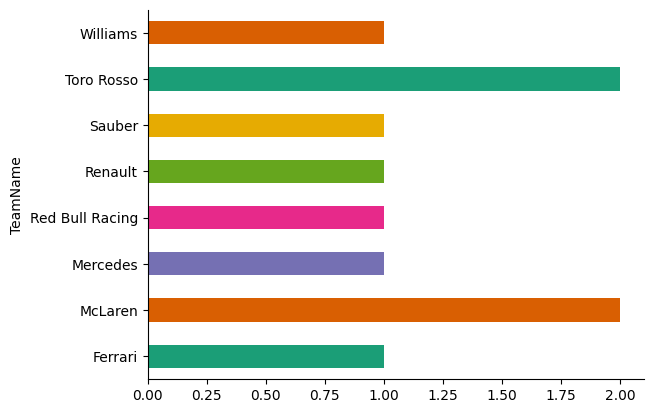

In [6]:
from matplotlib import pyplot as plt
import seaborn as sns
_df_1.groupby('TeamName').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

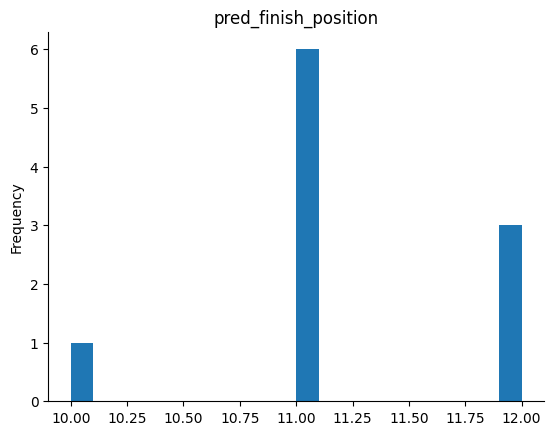

In [7]:
from matplotlib import pyplot as plt
_df_0['pred_finish_position'].plot(kind='hist', bins=20, title='pred_finish_position')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [9]:
def build_inference_postqual(df_hist, season:int, rnd:int):
    hist = df_hist[(df_hist["season"] < season)]
    quali = load_session(season, rnd, "Q")
    qdf = extract_quali_features(quali)
    df_form = compute_driver_recent_form(hist, window=5)
    last_form = df_form.groupby("DriverId").tail(1)[
        ["DriverId","finish_pos_rolling_mean","dnf_rate_rolling","points_rolling_mean"]
    ]
    inf = qdf.merge(last_form, on="DriverId", how="left")
    inf["grid_position"] = inf["quali_position"]
    inf["season"] = season; inf["round"] = rnd; inf["event_key"] = f"{season}_{rnd}"
    return inf

# Following to be Run after Q finishes
# post_inf = build_inference_postqual(df_hist, 2025, DUTCH_2025_ROUND)
# post_pred = predict_frame("/content/baseline_xgb_gpu.json", post_inf)
# post_pred[["pred_finish_position","Abbreviation","TeamName"]].head(10)


In [10]:
def get_predicted_winner(df):
    """
    Takes a DataFrame with columns ['driver', 'pred_finish_position']
    and returns the driver predicted to finish best (lowest position).
    """
    winner_row = df.loc[df['pred_finish_position'].idxmin()]
    return winner_row['driver'], winner_row['pred_finish_position']

data = {
    'driver': ['HAM','ALO','GAS','HAR','SAI','VER','STR','ERI','VET','VAN'],
    'pred_finish_position': [10,11,11,11,11,11,11,12,12,12]
}

import pandas as pd
df = pd.DataFrame(data)

winner, pos = get_predicted_winner(df)
print(f"🏁 Predicted winner: {winner} (Position {pos})")


🏁 Predicted winner: HAM (Position 10)
